In [1]:
import os

In [2]:
from langgraph.graph import MessagesState,StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode

In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [4]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

In [5]:
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

In [6]:
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [7]:
search = DuckDuckGoSearchRun()

In [8]:
search.invoke("who is a current president of USA?")

'... presidents are typically viewed as leaders of their political parties, major policymaking is significantly shaped by the outcome of presidential ... 请问为什么电压的英文是voltage,缩写却是u，而电流英文是current,缩写是I?通常物理量和该量的单位符号使用的字母是不同的。物理量的单位符号一般使用发明（发现）该物理量的科学家的姓 … Oct 24, 2014 · Hi everyone. What does this phrase in the snapshot mean? "No, Your Honor. I\'m current on all the rules." [Relevant phrase copied to post, DonnyB - moderator] Dec 28, 2023 · Current± Briefings: Tackling grid constraints as a developer In this edition of our Current± Briefings series we sat down with SNRG’s managing director Dan Nicholl to discuss … Jun 14, 2023 · To find out more, Current± spoke to Karl Bach, co-founder of Axle, on the company’s aspirations and its technology. Could you provide a bit of a background on Axle …'

In [9]:
tools = [add, multiply, divide, search]

In [10]:
llm_with_tools=llm.bind_tools(tools)

In [11]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

In [12]:
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [13]:
# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)

builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")

builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

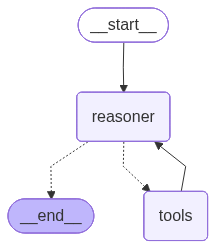

In [14]:
# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [15]:
messages = [HumanMessage(content="What is 2 times of first usa president's age?")]

In [16]:
messages = react_graph.invoke({"messages": messages})

In [17]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of first usa president's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (7j98wa8qd)
 Call ID: 7j98wa8qd
  Args:
    query: first usa president age
================================= Tool Message =================================
Name: duckduckgo_search

2 weeks ago - Former president Biden is the oldest of the five living U.S. presidents, age 82 years, 295 days . The youngest living former president is Barack Obama, age 64 years, 38 days. ... ^ This is the length of Cleveland's first (1889–1893) post-presidency, between his two terms in office. 5 days ago - George Washington ( February 22, 1732 [O.S. February 11, 1731] – December 14, 1799 ) was a Founding Father and the first president of the United States, serving from 1789 to 1797. As commander of the Continental Army, Washington led Patriot forces to victory in the Am

In [18]:
messages = [HumanMessage(content="What is the result when you add 100 years to the current age of Elon Musk?")]

In [19]:
messages = react_graph.invoke({"messages": messages})

In [20]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the result when you add 100 years to the current age of Elon Musk?
================================== Ai Message ==================================
Tool Calls:
  add (12e04n9j2)
 Call ID: 12e04n9j2
  Args:
    a: 100
    b: 51
================================= Tool Message =================================
Name: add

151
================================== Ai Message ==================================

The result when you add 100 years to the current age of Elon Musk is 151.


In [21]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [22]:
get_stock_price("AAPL")

230.03

In [23]:
# Node
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [24]:
tools = [add, multiply, divide, search, get_stock_price]

In [25]:
llm_with_tools = llm.bind_tools(tools)

In [26]:
class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

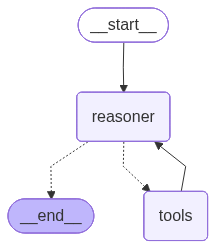

In [27]:
# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [28]:
response = react_graph.invoke({"query": "What is the stock price of Apple add 1000?", "messages": []})

In [29]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (b6wp25hmj)
 Call ID: b6wp25hmj
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

230.03
================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================

230.03 + 1000 = 1230.03
